## <center> Практическое задание к лекции №5

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
df = pd.read_csv("churn_data.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Избавимся от ненужных полей

In [41]:
df.drop(['RowNumber','CustomerId'], axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], shuffle=True, random_state=0, stratify=df['Exited'])

Для логистической регрессии предварительно стандартизируем числовые признаки, и применим One Hot Encoder  к категориальным.

Зададим списки признаков

In [44]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [45]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [46]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [47]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим логистическую регрессию. 

In [48]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [49]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [50]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10197051, 0.28741764, 0.04568888, 0.19303552, 0.21388212,
       0.0242263 , 0.10119441, 0.18924428, 0.10958856, 0.07106163])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [51]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict={
    'model':['LogReg'],
    'F-score':[fscore[ix]],
    'Precision':[precision[ix]],
    'Recall':[recall[ix]]
}

Best Threshold=0.2366474135099504, F-Score= 0.496, Precision= 0.407, Recall= 0.637


Отрисуем матрицу ошибок

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1518  473]
 [ 186  323]]


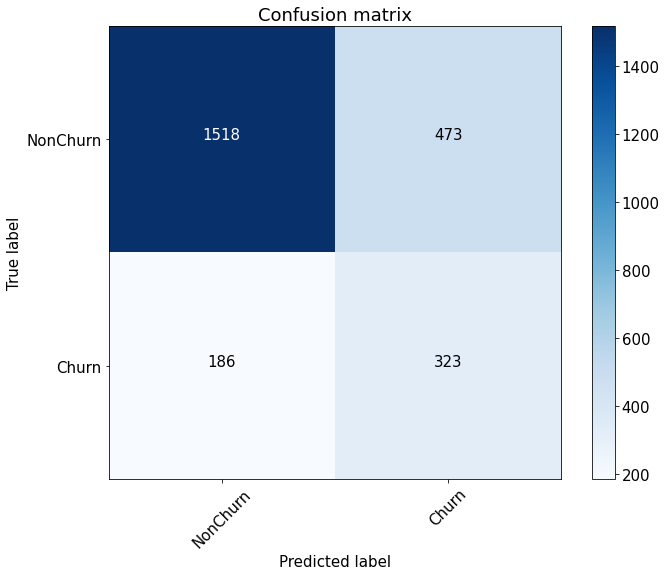

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

В модели из лекции(RandomForestClassifier) мы получили следующие показатели:  
$F-score=0.641\\Precision=0.653\\Recall=0.629$  
Дополним ими наш $\text{fin_dict}$

In [55]:
fin_dict['model'].append('RandFor')
fin_dict['F-score'].append(0.641)
fin_dict['Precision'].append(0.653)
fin_dict['Recall'].append(0.629)

Для модели RandomForestClassifier  
$TP=314\\FP=159\\FN=195\\TN=1832$  
Если принять во внимание что каждый клиент приносит нам 2 доллара, а расходы на его удержание составляют 1, то эта модель(в гипотетическом случае, что мы удерживаем всех клиентов, которых пытаемся удержать) принесет нам следующий результат: 314Х2=618 долл. -прибыль с удержаных клиентов, 159X1=159 долл. - потери на клиентах которые не собирались уходить, но модель их отнесла в отток($FP$),  и 195Х2=390 долл. упущенная прибыль на клиентах которых модель неправильно отметила как лояльных, но которые на самом деле попали в отток($FN$)  
Итого: $618-159-390=69$ долл.

Для модели логистической регрессии:  
$(323\cdot 2) - 473 - (186\cdot2) = 646-473-372=-199$ долл.   

градиентный бустинг

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [57]:
#обучим наш пайплайн
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [58]:
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds_gb[:10]

array([0.02036599, 0.11465145, 0.02295217, 0.04761298, 0.22451241,
       0.01325713, 0.14187688, 0.16083293, 0.20438141, 0.03579762])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict['model'].append('GradBoost')
fin_dict['F-score'].append(fscore[ix])
fin_dict['Precision'].append(precision[ix])
fin_dict['Recall'].append(recall[ix])

Best Threshold=0.326574794284067, F-Score= 0.622, Precision= 0.650, Recall= 0.595


Confusion matrix, without normalization
[[1828  163]
 [ 207  302]]


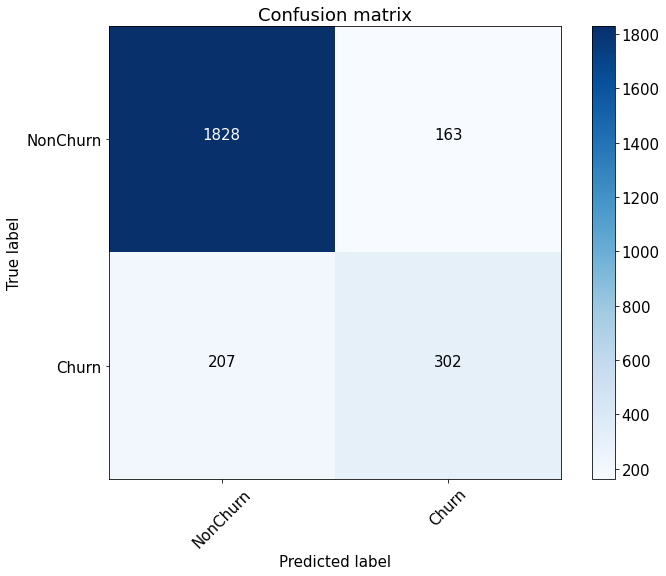

In [60]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для модели градиентного бустинга:  
$(302\cdot 2) - 163 - (207\cdot2) = 604-163-402=39$ долл.

Попробуем подобрать параметры для наших моделей

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [62]:
final_transformers1 = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers1.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))])

    final_transformers1.append((cont_col, cont_transformer))

In [63]:
feats1 = FeatureUnion(final_transformers1)

feature_processing1 = Pipeline([('feats', feats1)])

In [32]:
params={'classifier__n_estimators': [50, 100, 150, 200, 400, 600, 1000],
        'classifier__max_depth': np.arange(2, 13, 2),
        'classifier__max_features': ['auto', 'sqrt'],
        'classifier__min_samples_leaf': [1, 2, 3]
       }

In [35]:
pipeline_rf = Pipeline([
    ('features',feats1),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [36]:
grid = GridSearchCV(pipeline_rf,
                    param_grid=params,
                    cv=6,
                    refit=False,
                    scoring='f1')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 12,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__n_estimators': 150}

In [64]:
pipeline_rf = Pipeline([
    ('features',feats1),
    ('classifier', RandomForestClassifier(n_estimators= 150,max_depth=12, min_samples_leaf= 2,random_state = 42)),
])
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [65]:
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict['model'].append('RandForGS')
fin_dict['F-score'].append(fscore[ix])
fin_dict['Precision'].append(precision[ix])
fin_dict['Recall'].append(recall[ix])
font = {'size' : 15}



Best Threshold=0.3127294191783158, F-Score= 0.602, Precision= 0.610, Recall= 0.593


Confusion matrix, without normalization
[[1798  193]
 [ 208  301]]


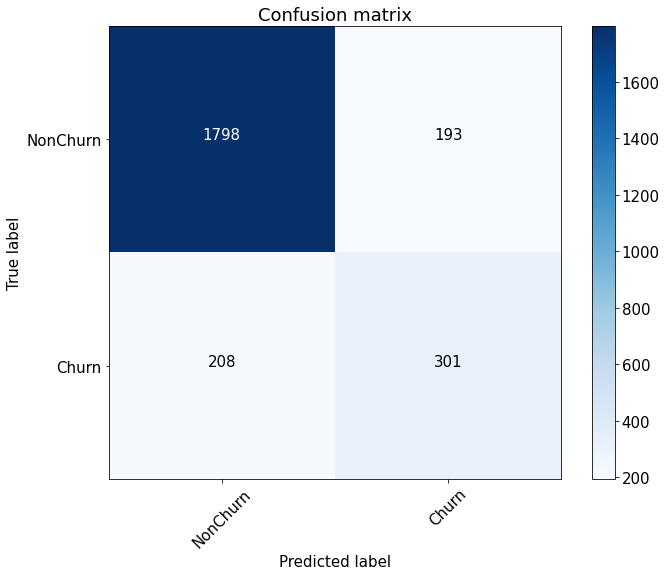

In [66]:
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для данной модели:  
$(301\cdot 2) - 193 - (208\cdot2) = 602-193-416=-7$ долл.

Подберем параметры для градиентного бустинга:

In [69]:
params={'classifier__n_estimators': [50, 100, 150, 200, 400, 600, 1000],
        'classifier__max_depth': np.arange(2, 10, 2),
        'classifier__learning_rate': [0.1, 0.01, 0.001, 0.0001],
        'classifier__max_features': ['auto', 'sqrt']
       }

In [70]:
pipeline_gbgs = Pipeline([
    ('features',feats1),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


In [71]:
grid = GridSearchCV(pipeline_gbgs,
                    param_grid=params,
                    cv=6,
                    refit=False,
                    scoring='f1')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 200}

In [72]:
pipeline_gbgs = Pipeline([
    ('features',feats1),
    ('classifier', GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 4, max_features = 'sqrt', random_state = 42)),
])

pipeline_gbgs.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [73]:
preds_gbgs = pipeline_gbgs.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_gbgs)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict['model'].append('GradBoostGS')
fin_dict['F-score'].append(fscore[ix])
fin_dict['Precision'].append(precision[ix])
fin_dict['Recall'].append(recall[ix])
font = {'size' : 15}

Best Threshold=0.30735629828916894, F-Score= 0.614, Precision= 0.614, Recall= 0.613


Confusion matrix, without normalization
[[1795  196]
 [ 198  311]]


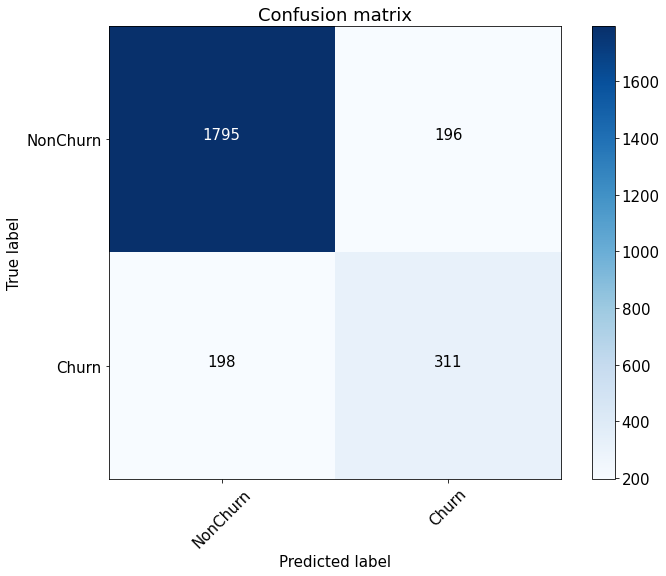

In [74]:
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gbgs>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для данной модели:  
$(311\cdot 2) - 196 - (198\cdot2) = 622-196-392=34$ долл.

In [78]:
fin_dict.update({'effect':[-199,69,39, -7, 34]})

In [79]:
res=pd.DataFrame(data=fin_dict).sort_values('effect', ascending=False)
res

,model,F-score,Precision,Recall,effect
1,RandFor,0.641000,0.653000,0.629000,69
2,GradBoost,0.621538,0.650215,0.595285,39
4,GradBoostGS,0.613569,0.614173,0.612967,34
3,RandForGS,0.601594,0.610101,0.593320,-7
0,LogReg,0.496172,0.406524,0.636542,-199


Из сравнения моделей видно, что наиболее подходящей метрикой для оценки моделей является f-score, которая балансирует модель по полноте и точности, помогая сокращать затраты на удержание и упущенную прибыль.